In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import requests
import os
from google.colab import userdata

In [3]:
tng_api_key = userdata.get('TNG_API_KEY')
baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":tng_api_key}

In [4]:
def get(path, params=None, out_filename=None):
    headers = {"api-key":tng_api_key}
    r = requests.get(path, params=params, headers=headers)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers or out_filename is not None:
        if out_filename is not None:
            filename = out_filename
        else:
            filename = r.headers['content-disposition'].split("filename=")[1]

        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r

In [7]:
r = get(baseUrl)

for simulation in r['simulations']: #only get TNG50
    if simulation['name'] == 'TNG50-1':
        url = simulation['url']
        break

tng50 = get(url)

url = 'http://www.tng-project.org/api/TNG50-1/snapshots/z=1.8/'
snapshot = get(url)

In [18]:
sub_urls = []
subs = []
for i in range(1, 6): # Snapshots 1 to 5
    sub_url = f"http://www.tng-project.org/api/TNG50-1/snapshots/{i}/subhalos/0/"
    sub_urls.append(sub_url)
    subs.append(get(sub_url))

cutout_request = {'gas':'Velocities,Coordinates,InternalEnergy,ElectronAbundance'}
cuts = []
for i, sub_url in enumerate(sub_urls):
    cuts.append(get(sub_url + "cutout.hdf5", cutout_request, out_filename=f"cut{i+1}"))

In [19]:
xs = []
ys = []
vels = []
us = []
xes = []

for i, cut_file in enumerate(cuts):
    with h5py.File(cut_file,'r') as f:
        xs.append(f['PartType0']['Coordinates'][:,0] - subs[i]['pos_x'])
        ys.append(f['PartType0']['Coordinates'][:,1] - subs[i]['pos_y'])
        vels.append(f['PartType0']['Velocities'][:])
        us.append(f['PartType0']['InternalEnergy'][:])
        xes.append(f['PartType0']['ElectronAbundance'][:])

In [20]:
Xh = 0.76
mp = 1.67e-27
kb = 1.38e-23
gamma = 5/3
unitRatio = 1e10

mus = []
Ts = []
vel_mags = []

for i in range(len(xes)):
    mu = 4 / (1 + 3*Xh + 4*Xh*xes[i]) * mp
    mus.append(mu)
    Ts.append((gamma-1)*unitRatio*mu*us[i]/kb)
    vel_mags.append(np.sqrt(np.sum(vels[i]**2, axis=1)))

In [21]:
counts1_list = []
counts2_list = []
bin_edges = None

for i in range(len(Ts)):
    counts1, current_bin_edges = np.histogram(Ts[i])
    counts2, current_bin_edges = np.histogram(vel_mags[i])
    counts1_list.append(counts1)
    counts2_list.append(counts2)
    if bin_edges is None:
        bin_edges = current_bin_edges

bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

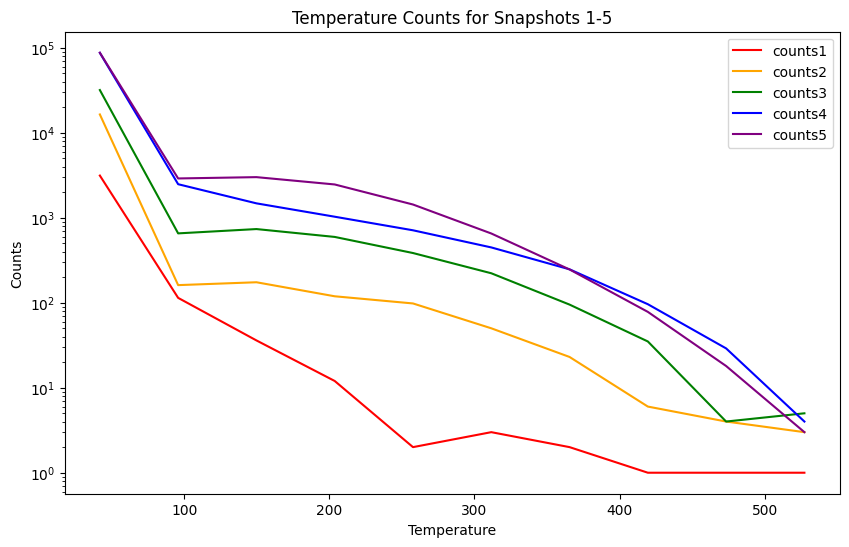

In [26]:
colors = ['red', 'orange', 'green', 'blue', 'purple']

plt.figure(figsize=(10, 6))
for i in range(len(counts1_list)):
    plt.plot(bin_centers, counts1_list[i], label=f'counts{i+1}', color=colors[i])

plt.yscale('log')
plt.ylabel('Counts')
plt.xlabel('Temperature')
plt.legend()
plt.title('Temperature Counts for Snapshots 1-5')
plt.show()

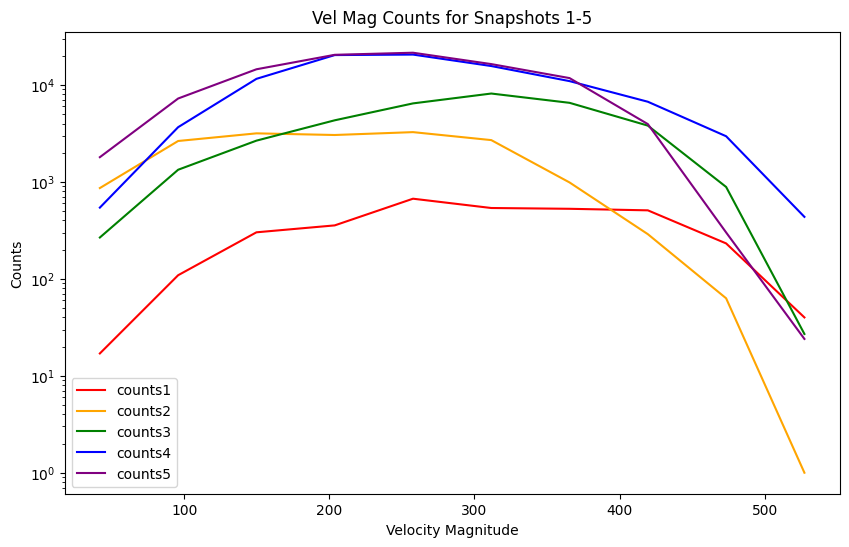

In [27]:
colors = ['red', 'orange', 'green', 'blue', 'purple']

plt.figure(figsize=(10, 6))
for i in range(len(counts2_list)):
    plt.plot(bin_centers, counts2_list[i], label=f'counts{i+1}', color=colors[i])

plt.yscale('log')
plt.ylabel('Counts')
plt.xlabel('Velocity Magnitude')
plt.legend()
plt.title('Vel Mag Counts for Snapshots 1-5')
plt.show()

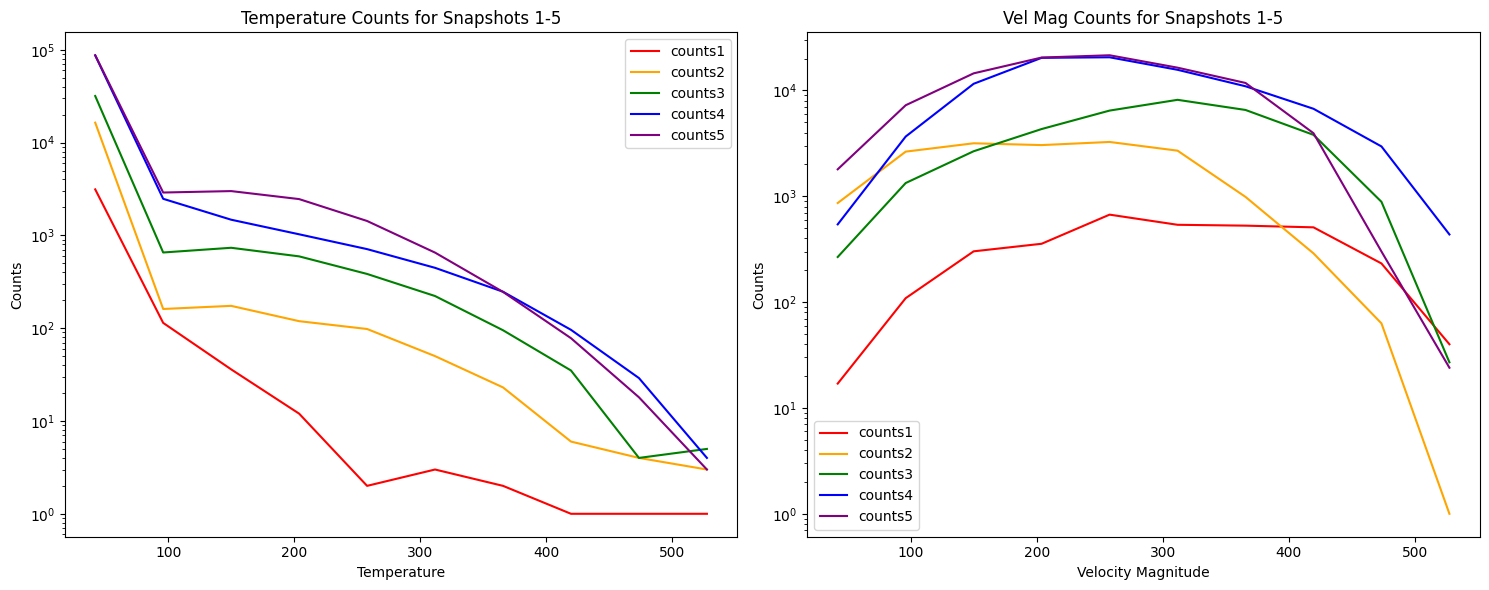

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
colors = ['red', 'orange', 'green', 'blue', 'purple']

for i in range(len(counts1_list)):
    axes[0].plot(bin_centers, counts1_list[i], label=f'counts{i+1}', color=colors[i])
    axes[1].plot(bin_centers, counts2_list[i], label=f'counts{i+1}', color=colors[i])

axes[0].set_yscale('log')
axes[0].set_ylabel('Counts')
axes[0].set_xlabel('Temperature')
axes[0].legend()
axes[0].set_title('Temperature Counts for Snapshots 1-5')

axes[1].set_yscale('log')
axes[1].set_ylabel('Counts')
axes[1].set_xlabel('Velocity Magnitude')
axes[1].legend()
axes[1].set_title('Vel Mag Counts for Snapshots 1-5')

plt.tight_layout()
plt.show()